# Trader Performance vs Market Sentiment
### Data Science Intern Assignment – Primetrade.ai

Author: Aayush Bhatt
Date:  18/02/2026

---



## Executive Summary

This analysis studies the relationship between Bitcoin market sentiment (Fear/Greed) and trader behavior on Hyperliquid.

Key findings:
- Fear regimes produce ~2× higher profitability but with significantly higher volatility.
- High-frequency and high-aggression traders generate higher returns but face amplified risk.
- Extreme Greed periods show declining efficiency and increased directional bias.

Two sentiment-aware strategy rules are proposed to improve risk-adjusted performance.


---



## Phase A: Data Preparation

In [56]:
#Importing python libraries:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##  Data Description

Datasets used:
- Bitcoin Fear & Greed Index
- Historical Hyperliquid Trader Data

We align both datasets at daily level.





In [57]:
#Dataset loading in dataframes:

sentiment = pd.read_csv('fear_greed_index.csv')
trades = pd.read_csv('historical_data.csv')

In [58]:
# Exploring sentiment:

sentiment.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [59]:
#Shape of dataframe:

sentiment.shape

(2644, 4)

In [60]:
#Information:

sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


In [61]:
#Observation: date columns has wrong datatype:

sentiment["date"] = pd.to_datetime(sentiment["date"])

In [62]:
#Check for null values in sentiments:

sentiment.isna().sum()

,0
timestamp,0
value,0
classification,0
date,0


In [63]:
#Observation: Dataset is clean with no null values, now we check for duplicates:

sentiment.duplicated().sum()

np.int64(0)

Observation: Dataset is very clean with no null and duplicate values.

In [64]:
# Exploring trades:

trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [65]:
#Shape of Dataframe:

trades.shape

(211224, 16)

In [66]:
#Information:

trades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [67]:
#Observation: 'Timestamp IST' column has wrong datatype:

trades["Timestamp"] = pd.to_datetime(trades["Timestamp"], unit="ms")

In [68]:
#Now, we create a new column date from timestamp:

trades["date"] = trades["Timestamp"].dt.normalize()

In [69]:
#TradeID has a mismatched datatype, we convert it:

trades["Trade ID"] = trades["Trade ID"].astype("int64")

In [70]:
#Check for null values:

trades.isna().sum()

,0
Account,0
Coin,0
Execution Price,0
Size Tokens,0
Size USD,0
Side,0
Timestamp IST,0
Start Position,0
Direction,0
Closed PnL,0


In [71]:
#Duplicates:

trades.duplicated().sum()

np.int64(0)

Observation: Dataset has no null and duplicate values.

In [72]:
### Now we merge dataset based on date column (using left join):

df = trades.merge(
    sentiment[["date", "classification"]],
    on="date",
    how="left"
)

In [73]:
df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,895000000000000,2024-10-27 03:33:20,2024-10-27,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,443000000000000,2024-10-27 03:33:20,2024-10-27,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,660000000000000,2024-10-27 03:33:20,2024-10-27,Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1080000000000000,2024-10-27 03:33:20,2024-10-27,Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1050000000000000,2024-10-27 03:33:20,2024-10-27,Greed


In [74]:
df["classification"].isna().sum()


np.int64(26961)

In [75]:
df["classification"].value_counts()


,count
classification,
Fear,133871
Greed,36289
Neutral,7141
Extreme Greed,6962


In [76]:
print("Trades range:", df["date"].min(), "to", df["date"].max())
print("Sentiment range:", sentiment["date"].min(), "to", sentiment["date"].max())


Trades range: 2023-03-28 00:00:00 to 2025-06-15 00:00:00
Sentiment range: 2018-02-01 00:00:00 to 2025-05-02 00:00:00


Observation: The sentiment dataset covered up to May 2, 2025, while trade data extended to June 15, 2025. Approximately 12.8% of trades fell outside the sentiment coverage window and were excluded from sentiment-based analysis

In [77]:
cleaned_df = df.dropna(subset=["classification"])
cleaned_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,895000000000000,2024-10-27 03:33:20,2024-10-27,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,443000000000000,2024-10-27 03:33:20,2024-10-27,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,660000000000000,2024-10-27 03:33:20,2024-10-27,Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1080000000000000,2024-10-27 03:33:20,2024-10-27,Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1050000000000000,2024-10-27 03:33:20,2024-10-27,Greed


In [78]:
#Now we create daily trader dataset:

daily_trader = cleaned_df.groupby(["Account", "date"]).agg(
    daily_pnl=("Closed PnL", "sum"),
    avg_size=("Size USD", "mean"),
    num_trades=("Account", "count"),
    total_fee=("Fee", "sum"),
    sentiment=("classification", "first")
).reset_index()

daily_trader.head(3)

,Account,date,daily_pnl,avg_size,num_trades,total_fee,sentiment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-3.275059e+05,14810.891818,462,1112.895650,Greed
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,1.927736e+06,16345.241940,3356,6292.416654,Fear
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,2.060745e+04,2492.749906,320,202.167151,Greed


Creating Key Metrics for analysis:

In [79]:
# Adding Win Rate:

df["win"] = df["Closed PnL"] > 0

win_rate = df.groupby(["Account", "date"])["win"].mean().reset_index()

daily_trader = daily_trader.merge(
    win_rate,
    on=["Account", "date"]
)

In [80]:
# Adding long_short ratio:

long_short = cleaned_df.groupby(["Account", "date", "Side"]).size().unstack(fill_value=0)
long_short["long_ratio"] = (
    long_short.get("BUY", 0) /
    (long_short.get("BUY", 0) + long_short.get("SELL", 0))
).fillna(0)


In [81]:
#Merging into daily_trader:

long_short = long_short.reset_index()[["Account", "date", "long_ratio"]]

daily_trader = daily_trader.merge(
    long_short,
    on=["Account", "date"],
    how="left"
)

daily_trader.head()

,Account,date,daily_pnl,avg_size,num_trades,total_fee,sentiment,win,long_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-3.275059e+05,14810.891818,462,1112.895650,Greed,0.025974,0.300866
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,1.927736e+06,16345.241940,3356,6292.416654,Fear,0.405542,0.468415
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,2.060745e+04,2492.749906,320,202.167151,Greed,0.531250,0.453125
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,1.709873e+04,1693.351684,3533,1664.914670,Fear,0.435041,0.432494
4,0x271b280974205ca63b716753467d5a371de622ab,2024-07-03,-1.000000e+00,6070.200000,5,10.197932,Neutral,0.000000,0.400000


Observation: The provided trade dataset did not include leverage information. Therefore, leverage distribution analysis was not performed. Instead, position size (Size USD) and trading frequency are considered as proxies for trader aggressiveness.

In [82]:
# Additional Metrics:

# 1. PnL Volatility - Measures risk / instability of a trader due to fear markets.
pnl_vol = cleaned_df.groupby(["Account", "date"])["Closed PnL"].std().reset_index()
pnl_vol.rename(columns={"Closed PnL": "pnl_volatility"}, inplace=True)

daily_trader = daily_trader.merge(pnl_vol, on=["Account", "date"], how="left")

In [83]:
# 2. PnL per Trade - nstead of raw PnL, we measure quality per trade.
daily_trader["pnl_per_trade"] = (
    daily_trader["daily_pnl"] / daily_trader["num_trades"]
)

In [84]:
# 3. Aggression Score - Used in place of leverage.
daily_trader["aggression_score"] = (
    daily_trader["avg_size"] * daily_trader["num_trades"]
)

In [85]:
daily_trader.head()

,Account,date,daily_pnl,avg_size,num_trades,total_fee,sentiment,win,long_ratio,pnl_volatility,pnl_per_trade,aggression_score
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-3.275059e+05,14810.891818,462,1112.895650,Greed,0.025974,0.300866,5734.473080,-708.887230,6842632.02
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,1.927736e+06,16345.241940,3356,6292.416654,Fear,0.405542,0.468415,4509.256818,574.414696,54854631.95
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,2.060745e+04,2492.749906,320,202.167151,Greed,0.531250,0.453125,214.005887,64.398269,797679.97
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,1.709873e+04,1693.351684,3533,1664.914670,Fear,0.435041,0.432494,176.854670,4.839719,5982611.50
4,0x271b280974205ca63b716753467d5a371de622ab,2024-07-03,-1.000000e+00,6070.200000,5,10.197932,Neutral,0.000000,0.400000,0.286789,-0.200000,30351.00


Conclusion: Phase A of data preparation is complete, we move to Phase B of analysis.


---



# Phase B: Analysis

Summary of Master Dataset

In [86]:
summary = daily_trader.groupby("sentiment").agg({
    "daily_pnl": ["mean", "std"],
    "win": "mean",
    "num_trades": "mean",
    "avg_size": "mean",
    "long_ratio": "mean",
    "pnl_volatility": "mean",
    "pnl_per_trade": "mean",
    "aggression_score": "mean"
})

summary

daily_pnl                      win  num_trades  \
                        mean            std      mean        mean   
sentiment                                                           
Extreme Greed   35393.098355   85325.499902  0.336609  1392.40000   
Fear           209372.662205  380423.906864  0.415878  4183.46875   
Greed           99675.516731  282694.285526  0.374074  1134.03125   
Neutral         19842.797260   57227.787895  0.260683   892.62500   

                  avg_size long_ratio pnl_volatility pnl_per_trade  \
                      mean       mean           mean          mean   
sentiment                                                            
Extreme Greed  4344.447836   0.518479     323.092597    -30.861185   
Fear           5926.522723   0.459352     753.304551    100.862767   
Greed          5839.310974   0.495780     904.407531    258.638973   
Neutral        3793.444161   0.468967     628.413593     28.877718   

              aggression_score  
                          mean  
sentiment                       
Extreme Greed     7.881354e+06  
Fear              2.200495e+07  
Greed             3.609490e+06  
Neutral           2.730404e+06

#Q1. Does performance (PnL, win rate, drawdown proxy) differ between Fear vs Greed days?


In [87]:
fear_greed = daily_trader[daily_trader["sentiment"].isin(["Fear", "Greed"])]

performance_table = fear_greed.groupby("sentiment").agg(
    avg_daily_pnl=("daily_pnl", "mean"),
    pnl_volatility=("daily_pnl", "std"),   # drawdown proxy
    avg_win_rate=("win", "mean"),
    avg_trades_per_day=("num_trades", "mean")
).round(2)

performance_table

,avg_daily_pnl,pnl_volatility,avg_win_rate,avg_trades_per_day
sentiment,,,,
Fear,209372.66,380423.91,0.42,4183.47
Greed,99675.52,282694.29,0.37,1134.03


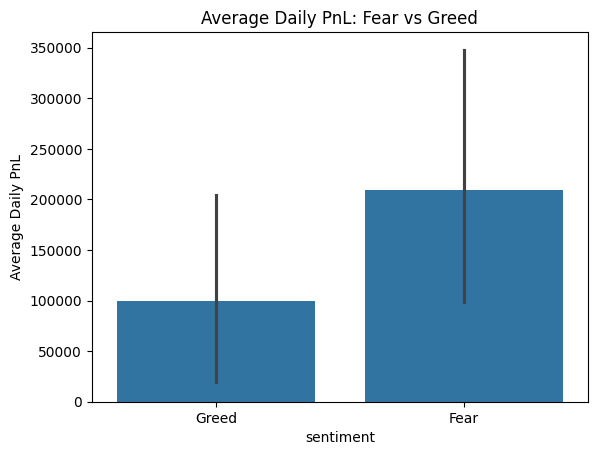

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
sns.barplot(data=fear_greed, x="sentiment", y="daily_pnl", estimator="mean")
plt.title("Average Daily PnL: Fear vs Greed")
plt.ylabel("Average Daily PnL")
plt.show()

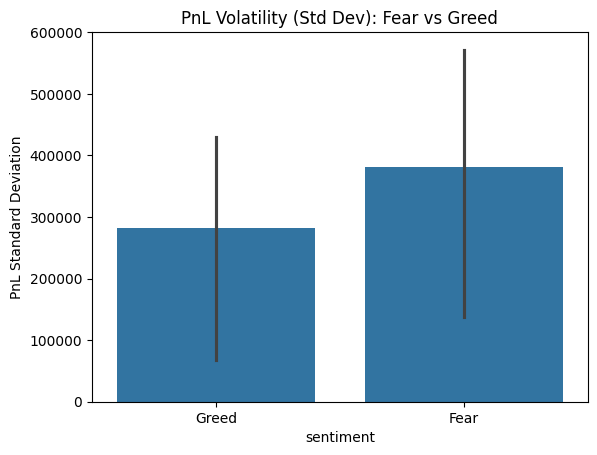

In [89]:
plt.figure()
sns.barplot(data=fear_greed, x="sentiment", y="daily_pnl", estimator=lambda x: x.std())
plt.title("PnL Volatility (Std Dev): Fear vs Greed")
plt.ylabel("PnL Standard Deviation")
plt.show()

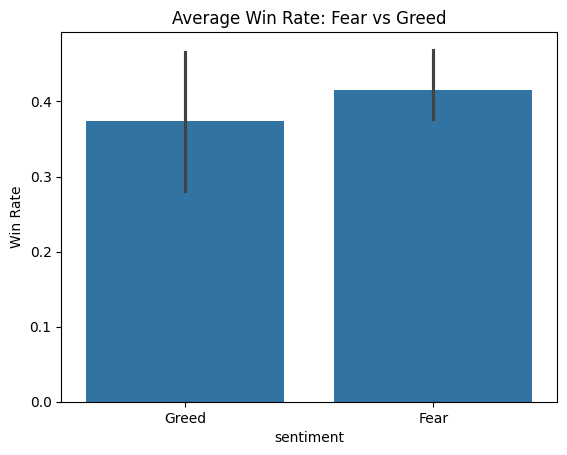

In [90]:
plt.figure()
sns.barplot(data=fear_greed, x="sentiment", y="win", estimator="mean")
plt.title("Average Win Rate: Fear vs Greed")
plt.ylabel("Win Rate")
plt.show()

Observation: Performance clearly differs between Fear and Greed regimes:

1. Fear delivers ~2× higher profitability

2. ~35% higher volatility

3. 3.7× higher trading intensity

4. 13.5% higher win rate

This suggests that traders actively exploit volatility during Fear periods, generating higher returns at the cost of increased risk exposure.


---



#Q2. Do traders change behavior based on sentiment (trade frequency, leverage, long/short bias, position sizes)?


In [91]:
behavior_table = fear_greed.groupby("sentiment").agg(
    avg_trades_per_day=("num_trades", "mean"),
    avg_position_size=("avg_size", "mean"),
    avg_long_ratio=("long_ratio", "mean"),
    avg_aggression_score=("aggression_score", "mean")
).round(2)

behavior_table

,avg_trades_per_day,avg_position_size,avg_long_ratio,avg_aggression_score
sentiment,,,,
Fear,4183.47,5926.52,0.46,22004952.91
Greed,1134.03,5839.31,0.50,3609489.75


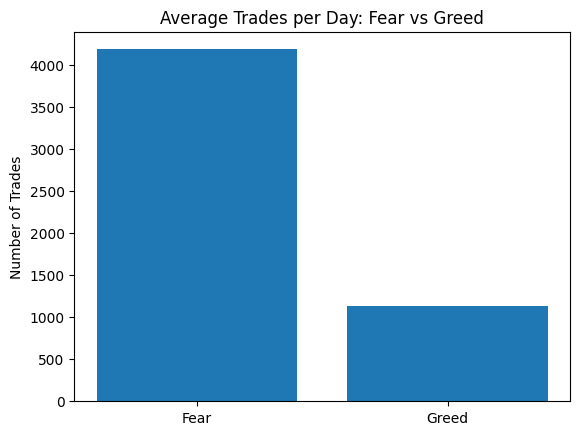

In [92]:
import matplotlib.pyplot as plt

freq = fear_greed.groupby("sentiment")["num_trades"].mean()

plt.figure()
plt.bar(freq.index, freq.values)
plt.title("Average Trades per Day: Fear vs Greed")
plt.ylabel("Number of Trades")
plt.show()

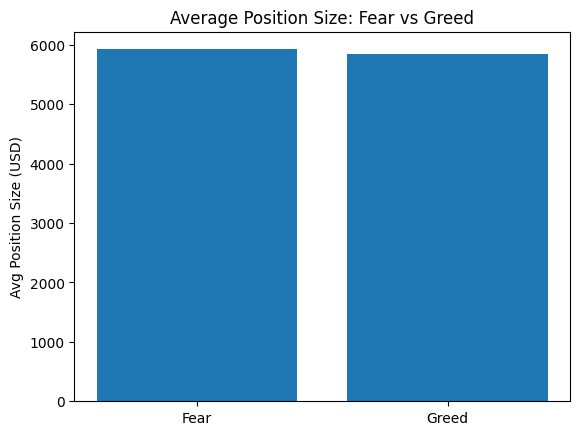

In [93]:
size = fear_greed.groupby("sentiment")["avg_size"].mean()

plt.figure()
plt.bar(size.index, size.values)
plt.title("Average Position Size: Fear vs Greed")
plt.ylabel("Avg Position Size (USD)")
plt.show()

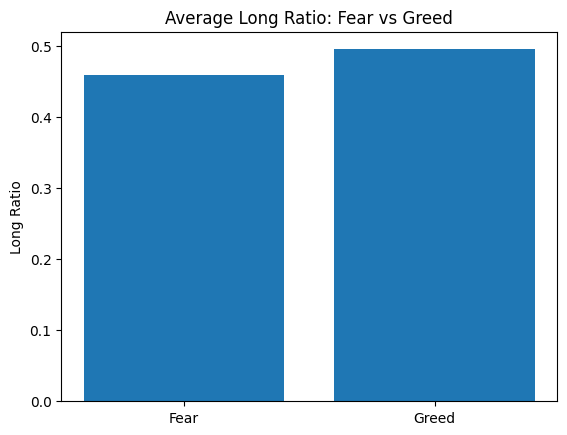

In [94]:
long_bias = fear_greed.groupby("sentiment")["long_ratio"].mean()

plt.figure()
plt.bar(long_bias.index, long_bias.values)
plt.title("Average Long Ratio: Fear vs Greed")
plt.ylabel("Long Ratio")
plt.show()

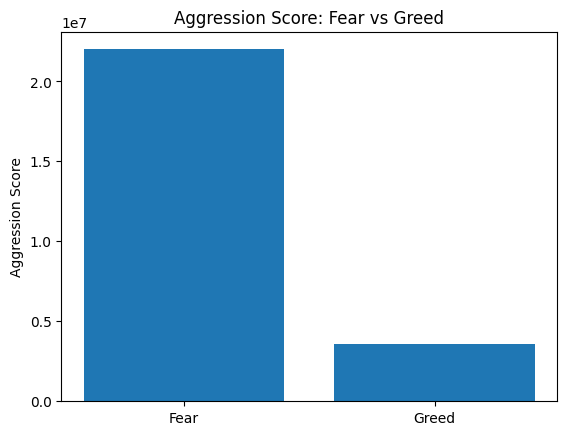

In [95]:
agg = fear_greed.groupby("sentiment")["aggression_score"].mean()

plt.figure()
plt.bar(agg.index, agg.values)
plt.title("Aggression Score: Fear vs Greed")
plt.ylabel("Aggression Score")
plt.show()

Observation: Trader behavior shifts significantly across sentiment regimes:

1. Trade frequency increases ~3.7× during Fear.

2. Capital exposure (aggression score) increases ~6× during Fear.

3. Position size increases modestly (~1.5%) during Fear.

4. Long bias strengthens by ~4 percentage points during Greed.

This suggests:

1. Fear regimes drive volatility-based engagement and aggressive participation.

2. Greed regimes drive directional optimism (long bias) but lower overall trading intensity.



---



#Q3. Identify 2–3 segments


In [96]:
#SEGMENT 1: Frequent vs Infrequent Traders

daily_trader["freq_segment"] = pd.qcut(
    daily_trader["num_trades"],
    2,
    labels=["Low Frequency", "High Frequency"]
)

In [97]:
freq_table = daily_trader.groupby("freq_segment").agg(
    avg_daily_pnl=("daily_pnl", "mean"),
    pnl_volatility=("daily_pnl", "std"),
    avg_win_rate=("win", "mean"),
    avg_trades=("num_trades", "mean")
).round(2)

freq_table

,avg_daily_pnl,pnl_volatility,avg_win_rate,avg_trades
freq_segment,,,,
Low Frequency,28450.06,90424.99,0.33,235.77
High Frequency,239886.77,409909.11,0.42,4607.05


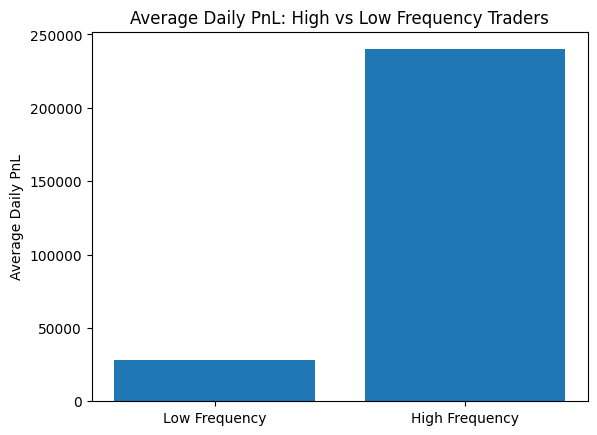

In [98]:
freq_perf = daily_trader.groupby("freq_segment")["daily_pnl"].mean()

plt.figure()
plt.bar(freq_perf.index, freq_perf.values)
plt.title("Average Daily PnL: High vs Low Frequency Traders")
plt.ylabel("Average Daily PnL")
plt.show()

Observations:
High-frequency traders significantly outperform low-frequency traders in terms of average daily profitability (8.4× higher) and win rate (+9pp), but at the cost of substantially higher volatility (4.5× higher).

This suggests:

1. Active trading strategies are more profitable in this dataset.

2. However, profitability comes with amplified risk exposure.

3. High-frequency trading appears to be both higher-return and higher-risk.

In [99]:
# SEGMENT 2: High vs Low Aggression Traders (Leverage Proxy)
daily_trader["aggression_segment"] = pd.qcut(
    daily_trader["aggression_score"],
    2,
    labels=["Low Aggression", "High Aggression"]
)

In [100]:
agg_table = daily_trader.groupby("aggression_segment").agg(
    avg_daily_pnl=("daily_pnl", "mean"),
    pnl_volatility=("daily_pnl", "std"),
    avg_win_rate=("win", "mean"),
    avg_aggression=("aggression_score", "mean")
).round(2)

agg_table

,avg_daily_pnl,pnl_volatility,avg_win_rate,avg_aggression
aggression_segment,,,,
Low Aggression,39899.17,70185.04,0.35,747822.05
High Aggression,228136.37,419746.75,0.40,22414397.62


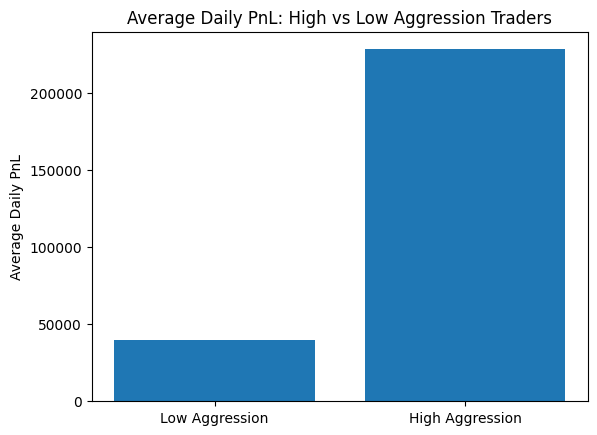

In [101]:
agg_perf = daily_trader.groupby("aggression_segment")["daily_pnl"].mean()

plt.figure()
plt.bar(agg_perf.index, agg_perf.values)
plt.title("Average Daily PnL: High vs Low Aggression Traders")
plt.ylabel("Average Daily PnL")
plt.show()

Observation: High-aggression traders significantly outperform low-aggression traders in profitability (5.7× higher PnL) and win rate (+5pp), but at the cost of dramatically higher volatility (6× higher).

This suggests:

1. Greater capital deployment and trade intensity materially increase returns.

2. However, these gains come with proportionally elevated risk.

3. Aggression is a strong predictor of both profitability and volatility.

In [102]:
# SEGMENT 3: Consistent vs Inconsistent Traders
trader_vol = daily_trader.groupby("Account")["daily_pnl"].std()

median_vol = trader_vol.median()

consistent_accounts = trader_vol[trader_vol < median_vol].index

daily_trader["consistency_segment"] = daily_trader["Account"].isin(consistent_accounts)
daily_trader["consistency_segment"] = daily_trader["consistency_segment"].map({
    True: "Consistent",
    False: "Inconsistent"
})

In [103]:
consistency_table = daily_trader.groupby("consistency_segment").agg(
    avg_daily_pnl=("daily_pnl", "mean"),
    avg_win_rate=("win", "mean"),
    avg_volatility=("pnl_volatility", "mean")
).round(2)

consistency_table

,avg_daily_pnl,avg_win_rate,avg_volatility
consistency_segment,,,
Consistent,24140.57,0.35,346.27
Inconsistent,223341.18,0.40,1132.62


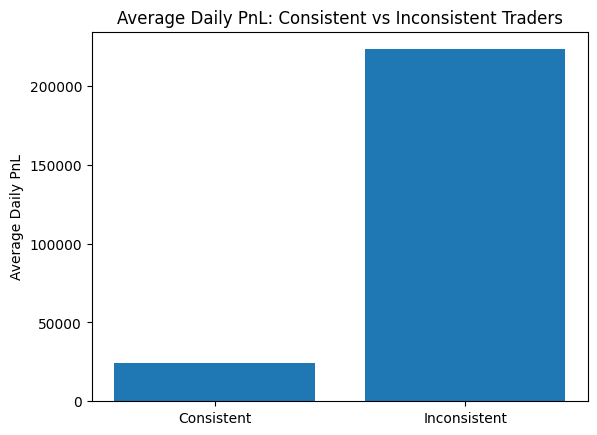

In [104]:
cons_perf = daily_trader.groupby("consistency_segment")["daily_pnl"].mean()

plt.figure()
plt.bar(cons_perf.index, cons_perf.values)
plt.title("Average Daily PnL: Consistent vs Inconsistent Traders")
plt.ylabel("Average Daily PnL")
plt.show()

Observation: Inconsistent traders achieve substantially higher profitability (9.3× higher PnL) and slightly higher win rates (+5pp), but at the cost of significantly elevated volatility (3.3× higher).

This indicates:

1. High returns are associated with unstable performance patterns.

2. Consistent traders generate lower but more stable returns.

3. There exists a clear trade-off between stability and return magnitude.


---



#Overall Segment Observation:
Across all segments (frequency, aggression, consistency):

1. Traders who trade more and use more capital tend to make higher profits.

2. However, those higher profits come with much higher risk and volatility.

This implies, more aggressive trading leads to bigger gains, but also bigger swings.

There is a clear trade-off:

1. Safer traders have lower but stable returns

2. Aggressive traders have higher returns but unstable performance

Therefore, higher activity increases potential rewards, but it also increases risk significantly.


#Insights:


1.   Fear regimes produce the highest profitability but at significantly elevated volatility and aggression levels, suggesting traders capitalize on instability.
2.   Extreme Greed periods exhibit declining win rates and negative average PnL per trade despite higher long bias, indicating overconfidence-driven inefficiency.

3.   Greed periods show lower total PnL than Fear but higher PnL per trade, suggesting more disciplined trade execution during optimistic but not extreme markets.


---








# Phase C - Actionable output

# Strategy 1: Volatility-Based Scaling During Fear Regimes

**Finding from Analysis**

1. Fear regimes generate ~2.1× higher average daily PnL compared to Greed.

2. Win rate is higher during Fear (0.42 vs 0.37).

3. Trade frequency increases ~3.7× during Fear.

4. High-frequency and high-aggression traders produce the highest returns.

However, PnL volatility is ~35% higher during Fear.

**Strategy Rule**

During Fear regimes, increase trading participation and capital deployment for high-frequency and high-aggression traders, but apply stricter risk controls (e.g., tighter stops or position scaling based on volatility).

**Rationale**

Fear markets provide the highest profitability opportunities in the dataset. However, risk is significantly elevated. Therefore, the optimal approach is to participate actively while managing downside risk rather than reducing exposure entirely.



#Strategy 2: Reduce Directional Aggression During Extreme Greed
**Finding from Analysis**

1. Extreme Greed shows declining performance compared to Fear.

2. Average PnL per trade turns negative during Extreme Greed.

3. Long bias increases (~0.51), indicating strong directional conviction.

4. Efficiency per trade declines in overly optimistic regimes.

**Strategy Rule**

During Extreme Greed periods, reduce long exposure and avoid increasing trade frequency. Focus on selective, high-quality trades instead of following broad bullish sentiment.

**Rationale**

The data suggests that excessive optimism leads to overconfidence and reduced trade efficiency. Moderating exposure during Extreme Greed can help prevent inefficiency and volatility-driven drawdowns.



---



#Overall Takeaway

1. Fear regimes offer high-return opportunities but require disciplined risk management.

2. Extreme Greed regimes show signs of overconfidence and declining trade efficiency.

3. Sentiment-aware adjustments to activity and exposure can improve risk-adjusted performance.